<a href="https://colab.research.google.com/github/MatheusBLQueiroz/Esp/blob/master/Projeto_Abastecimento_MBLQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ALUNO: MATHEUS BAÍA DE LUCENA QUEIROZ

DISCIPLINA: INTRODUÇÃO A CIÊNCIA DE DADOS

PROJETO: ANALISADOR DE ABASTECIMENTO DE UM LABORATÓRIO

Resumo: Este projeto atua em 5 pilares solucionar um problema REAL:

        1 - Prever desabastecimento de insumos em um laboratório de análises clínicas, ambiente em que um desabastecimento prejudicar pacientes doentes;
        2 - Oferecer relatório para supervisão e PCP da empresa, organizado por fornecedor e gravidade;
        3- Realizar análise de custo mensal. Utilizando-se para isto, a estatística;
        4 - Criar ferramentas de investigação de anomalias;
        5 - Automatizar todos os pontos anteriores. Permitindo análise rápida e diária.


        Neste trabalho, pelo menos um elemento de cada tópico das aulas foi utilizado. 

In [0]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from math import log

IMPORTANDO INFORMAÇÕES SOBRE O TEMPO ATUAL


In [0]:
from datetime import datetime

datetime_ob=datetime.now() #importa data e hora completa atualmente
current_month = datetime_ob.month #resgata mês atual
current_day=datetime_ob.day #resgata dia atual




# PRÉ PROCESSAMENTO E IMPORTAÇÃO DE DADOS

IMPORTANDO DATASET BASE E PRÉ PROCESSAMENTO PARTE 1

In [354]:
#importa arquivo com dados do laboratório e o do armazém. O arquivo se chama COLETIVA e é extraído do sistema de logística da empresa, o SAP.
coletiva_mnu=pd.read_csv("https://raw.githubusercontent.com/MatheusBLQueiroz/Esp/master/colsuper.csv",encoding = "ISO-8859-1", sep=";", decimal=",", thousands=".")

#display mostra .head() a qualquer momento no código. Aqui vemos a "cara" da planilha importada
display(coletiva_mnu.head())  

#observando mais linhas, nota-se que a coluna "Centro", possui dois códigos: D969 (laboratório) e DA04 (armazém), é necessário separar
display(coletiva_mnu.iloc[0:30,:]) 

coletiva_mnu['Centro'] = coletiva_mnu['Centro'].astype('category')
coletiva_mnu['Descrição'] = coletiva_mnu['Descrição'].astype('category')

display(coletiva_mnu.dtypes)





,Estoque,Centro,Área MRP,Material,Descrição,Saldo,Saldo Disp.,Estoque p/Armazenar,UM,Preço Unit.,Valor Estoque,Est.Seg.(qtd),Pto Reab.,Tipo Material,Tipo MRP,Planejador MRP,Cobertura Estoque s/ entradas,Cobertura Estoque c/ entradas,Fornecedor,Descr. Forn.,Lead Time Total,Prazo Entrega Prevista (Dias),Tempo de Processamento EM,Código ABC,Tamanho do lote MRP,Tamanho mínimo lote,Tamanho máximo lote,Tamanho fixo do lote,Lote Multiplo,Estoque máximo,Perfil de Cobertura,Descrição do Perfil,Estoque Seg(MARC),Calendário de Planejamento,Descrição do Calendário,Centro Abastecedor,Grau atend. (%),Qtd em Pedido de Compras,Nec.NOV/2019,Nec.DEZ/2019,...,Cons.JAN/2019,Cons.FEV/2019,Cons.MAR/2019,Cons.ABR/2019,Cons.MAI/2019,Cons.JUN/2019,Cons.JUL/2019,Cons.AGO/2019,Cons.SET/2019,Cons.OUT/2019,Cons.NOV/2019,Pedido 1,Próxima Entrega,Dt. Conf. 1,Quantidade,Pedido 2,2a Entrega,Dt. Conf. 2,Quantidade.1,Pedido 3,3a Entrega,Dt. Conf. 3,Quantidade.2,Temp.Armaz.,Perfil MRP,Descrição Perfil MRP,Dias sem Saídas,Dias sem Entradas,Excesso Estoque,Quantidade em Excesso,Dias de Excesso de Estoque,Excesso de Estoque (pedido),Quantidade em Excesso (pedido),Dias em Execesso (pedido),Faturamento minimo,Quantidade em Separação,Stat.Mat.,Des.Status,Num.Mat.Fab.,Materiais Substituídos
0,NaN,DA04,NaN,10000841,TB SOL SALINA 0.85% 3ML P.LABOR,979.0,940.0,0.0,UN,1.06,1034.77,1424.808,0.0,ZROH,PD,22.0,11.8,20.0,NaN,NaN,7,3,4,C,Z1,50.0,0.0,0.0,50.0,0.0,18.0,Cobertura 18 dias,0.0,QUS,FORN. QUI - SEMANAL,NaN,99.0,650.0,116.0,2153.0,...,0.0,351.0,1299.0,3350.0,1102.0,340.0,2650.0,2694.0,1750.0,2800.0,2206.0,4.500309e+09,27/11/2019,NaN,100.0,4.500309e+09,27/11/2019,NaN,500.0,4.500309e+09,27/11/2019,NaN,50.0,8.0,NaN,NaN,1,4,@08@,0.0,0,@08@,0.0,0.0,NaN,39.0,0,LIBERADO,03545,NaN
1,NaN,DA04,NaN,10000841,TB SOL SALINA 0.85% 3ML P.LABOR,979.0,940.0,0.0,UN,1.06,1034.77,1424.808,0.0,ZROH,PD,22.0,11.8,20.0,NaN,NaN,7,3,4,C,Z1,50.0,0.0,0.0,50.0,0.0,18.0,Cobertura 18 dias,0.0,QUS,FORN. QUI - SEMANAL,NaN,99.0,650.0,116.0,2153.0,...,0.0,351.0,1299.0,3350.0,1102.0,340.0,2650.0,2694.0,1750.0,2800.0,2206.0,4.500309e+09,27/11/2019,NaN,100.0,4.500309e+09,27/11/2019,NaN,500.0,4.500309e+09,27/11/2019,NaN,50.0,8.0,NaN,NaN,1,4,@08@,0.0,0,@08@,0.0,0.0,NaN,39.0,0,LIBERADO,03545,NaN
2,NaN,DA04,NaN,10000841,TB SOL SALINA 0.85% 3ML P.LABOR,979.0,940.0,0.0,UN,1.06,1034.77,1424.808,0.0,ZROH,PD,22.0,11.8,20.0,NaN,NaN,7,3,4,C,Z1,50.0,0.0,0.0,50.0,0.0,18.0,Cobertura 18 dias,0.0,QUS,FORN. QUI - SEMANAL,NaN,99.0,650.0,116.0,2153.0,...,0.0,351.0,1299.0,3350.0,1102.0,340.0,2650.0,2694.0,1750.0,2800.0,2206.0,4.500309e+09,27/11/2019,NaN,100.0,4.500309e+09,27/11/2019,NaN,500.0,4.500309e+09,27/11/2019,NaN,50.0,8.0,NaN,NaN,1,4,@08@,0.0,0,@08@,0.0,0.0,NaN,39.0,0,LIBERADO,03545,NaN
3,NaN,DA04,NaN,10000841,TB SOL SALINA 0.85% 3ML P.LABOR,979.0,940.0,0.0,UN,1.06,1034.77,1424.808,0.0,ZROH,PD,22.0,11.8,20.0,0020008079,PLAST LABOR IND.E COM.DE EQUIP.HOSP,7,3,4,C,Z1,50.0,0.0,0.0,50.0,0.0,18.0,Cobertura 18 dias,0.0,QUS,FORN. QUI - SEMANAL,NaN,99.0,650.0,116.0,2153.0,...,0.0,351.0,1299.0,3350.0,1102.0,340.0,2650.0,2694.0,1750.0,2800.0,2206.0,4.500309e+09,27/11/2019,NaN,100.0,4.500309e+09,27/11/2019,NaN,500.0,4.500309e+09,27/11/2019,NaN,50.0,8.0,NaN,NaN,1,4,@08@,0.0,0,@08@,0.0,0.0,@08@,39.0,0,LIBERADO,03545,NaN
4,NaN,DA04,NaN,10000841,TB SOL SALINA 0.85% 3ML P.LABOR,979.0,940.0,0.0,UN,1.06,1034.77,1424.808,0.0,ZROH,PD,22.0,11.8,20.0,0020008079,PLAST LABOR IND.E COM.DE EQUIP.HOSP,7,3,4,C,Z1,50.0,0.0,0.0,50.0,0.0,18.0,Cobertura 18 dias,0.0,QUS,FORN. QUI - SEMANAL,NaN,99.0,650.0,116.0,2153.0,...,0.0,351.0,1299.0,3350.0,1102.0,340.0,2650.0,2694.0,1750.0,2800.0,2206.0,4.500309e+09,27/11/2019,NaN,100.0,4.500309e+09,27/11/2019,NaN,500.0,4.500309e+09,27/11/2019,NaN,50.0,8.0,NaN,NaN,1,4,@08@,0.0,0,@08@,0.0,0.0,@08@,39.0,0,LIBERADO,03545,NaN


,Estoque,Centro,Área MRP,Material,Descrição,Saldo,Saldo Disp.,Estoque p/Armazenar,UM,Preço Unit.,Valor Estoque,Est.Seg.(qtd),Pto Reab.,Tipo Material,Tipo MRP,Planejador MRP,Cobertura Estoque s/ entradas,Cobertura Estoque c/ entradas,Fornecedor,Descr. Forn.,Lead Time Total,Prazo Entrega Prevista (Dias),Tempo de Processamento EM,Código ABC,Tamanho do lote MRP,Tamanho mínimo lote,Tamanho máximo lote,Tamanho fixo do lote,Lote Multiplo,Estoque máximo,Perfil de Cobertura,Descrição do Perfil,Estoque Seg(MARC),Calendário de Planejamento,Descrição do Calendário,Centro Abastecedor,Grau atend. (%),Qtd em Pedido de Compras,Nec.NOV/2019,Nec.DEZ/2019,...,Cons.JAN/2019,Cons.FEV/2019,Cons.MAR/2019,Cons.ABR/2019,Cons.MAI/2019,Cons.JUN/2019,Cons.JUL/2019,Cons.AGO/2019,Cons.SET/2019,Cons.OUT/2019,Cons.NOV/2019,Pedido 1,Próxima Entrega,Dt. Conf. 1,Quantidade,Pedido 2,2a Entrega,Dt. Conf. 2,Quantidade.1,Pedido 3,3a Entrega,Dt. Conf. 3,Quantidade.2,Temp.Armaz.,Perfil MRP,Descrição Perfil MRP,Dias sem Saídas,Dias sem Entradas,Excesso Estoque,Quantidade em Excesso,Dias de Excesso de Estoque,Excesso de Estoque (pedido),Quantidade em Excesso (pedido),Dias em Execesso (pedido),Faturamento minimo,Quantidade em Separação,Stat.Mat.,Des.Status,Num.Mat.Fab.,Materiais Substituídos
0,NaN,DA04,NaN,10000841,TB SOL SALINA 0.85% 3ML P.LABOR,979.0,940.0,0.0,UN,1.06,1034.77,1424.808,0.0,ZROH,PD,22.0,11.8,20.0,NaN,NaN,7,3,4,C,Z1,50.0,0.0,0.0,50.0,0.0,18.0,Cobertura 18 dias,0.0,QUS,FORN. QUI - SEMANAL,NaN,99.0,650.0,116.000,2153.000,...,0.0,351.0,1299.0,3350.0,1102.0,340.0,2650.0,2694.0,1750.0,2800.0,2206.0,4.500309e+09,27/11/2019,NaN,100.0,4.500309e+09,27/11/2019,NaN,500.0,4.500309e+09,27/11/2019,NaN,50.0,8.0,NaN,NaN,1,4,@08@,0.00,0,@08@,0.0,0.0,NaN,39.0,0,LIBERADO,03545,NaN
1,NaN,DA04,NaN,10000841,TB SOL SALINA 0.85% 3ML P.LABOR,979.0,940.0,0.0,UN,1.06,1034.77,1424.808,0.0,ZROH,PD,22.0,11.8,20.0,NaN,NaN,7,3,4,C,Z1,50.0,0.0,0.0,50.0,0.0,18.0,Cobertura 18 dias,0.0,QUS,FORN. QUI - SEMANAL,NaN,99.0,650.0,116.000,2153.000,...,0.0,351.0,1299.0,3350.0,1102.0,340.0,2650.0,2694.0,1750.0,2800.0,2206.0,4.500309e+09,27/11/2019,NaN,100.0,4.500309e+09,27/11/2019,NaN,500.0,4.500309e+09,27/11/2019,NaN,50.0,8.0,NaN,NaN,1,4,@08@,0.00,0,@08@,0.0,0.0,NaN,39.0,0,LIBERADO,03545,NaN
2,NaN,DA04,NaN,10000841,TB SOL SALINA 0.85% 3ML P.LABOR,979.0,940.0,0.0,UN,1.06,1034.77,1424.808,0.0,ZROH,PD,22.0,11.8,20.0,NaN,NaN,7,3,4,C,Z1,50.0,0.0,0.0,50.0,0.0,18.0,Cobertura 18 dias,0.0,QUS,FORN. QUI - SEMANAL,NaN,99.0,650.0,116.000,2153.000,...,0.0,351.0,1299.0,3350.0,1102.0,340.0,2650.0,2694.0,1750.0,2800.0,2206.0,4.500309e+09,27/11/2019,NaN,100.0,4.500309e+09,27/11/2019,NaN,500.0,4.500309e+09,27/11/2019,NaN,50.0,8.0,NaN,NaN,1,4,@08@,0.00,0,@08@,0.0,0.0,NaN,39.0,0,LIBERADO,03545,NaN
3,NaN,DA04,NaN,10000841,TB SOL SALINA 0.85% 3ML P.LABOR,979.0,940.0,0.0,UN,1.06,1034.77,1424.808,0.0,ZROH,PD,22.0,11.8,20.0,0020008079,PLAST LABOR IND.E COM.DE EQUIP.HOSP,7,3,4,C,Z1,50.0,0.0,0.0,50.0,0.0,18.0,Cobertura 18 dias,0.0,QUS,FORN. QUI - SEMANAL,NaN,99.0,650.0,116.000,2153.000,...,0.0,351.0,1299.0,3350.0,1102.0,340.0,2650.0,2694.0,1750.0,2800.0,2206.0,4.500309e+09,27/11/2019,NaN,100.0,4.500309e+09,27/11/2019,NaN,500.0,4.500309e+09,27/11/2019,NaN,50.0,8.0,NaN,NaN,1,4,@08@,0.00,0,@08@,0.0,0.0,@08@,39.0,0,LIBERADO,03545,NaN
4,NaN,DA04,NaN,10000841,TB SOL SALINA 0.85% 3ML P.LABOR,979.0,940.0,0.0,UN,1.06,1034.77,1424.808,0.0,ZROH,PD,22.0,11.8,20.0,0020008079,PLAST LABOR IND.E COM.DE EQUIP.HOSP,7,3,4,C,Z1,50.0,0.0,0.0,50.0,0.0,18.0,Cobertura 18 dias,0.0,QUS,FORN. QUI - SEMANAL,NaN,99.0,650.0,116.000,2153.000,...,0.0,351.0,1299.0,3350.0,1102.0,340.0,2650.0,2694.0,1750.0,2800.0,2206.0,4.500309e+09,27/11/2019,NaN,100.0,4.500309e+09,27/11/2019,NaN,500.0,4.500309e+09,27/11/2019,NaN,50.0,8.0,NaN,NaN,1,4,@08@,0.00,0,@08@,0.0,0.0,@08@,39.0,0,LIBERADO,03545,NaN
5,NaN,DA04,NaN,10000841,TB SOL SALINA 0.85% 3ML P.LABOR,979.0,940.0,0.0,UN,1.06,1034.77,1424.808,0.0,ZROH,PD,22.0,11.8,20.0,0020008079,PLAST LABOR IND.E COM.DE EQUIP.HOSP,

Estoque                     float64
Centro                     category
Área MRP                    float64
Material                      int64
Descrição                  category
                             ...   
Quantidade em Separação     float64
Stat.Mat.                     int64
Des.Status                   object
Num.Mat.Fab.                 object
Materiais Substituídos       object
Length: 101, dtype: object

CRIANDO DF IMPORTANTES

In [0]:
#filtra linhas com dados do laboratório (chama-se d969 no SAP)

coletiva_d969=coletiva_mnu[coletiva_mnu['Centro']=='D969']   

#filtra linhas com dados do armazém (chama-se da04 no SAP, e abastece o laboratório)
coletiva_da04=coletiva_mnu[coletiva_mnu['Centro']=='DA04'] 


PRÉ PROCESSAMENTO (HÁ MUITAS DUPLICATAS) - Parte 2




In [356]:
#CONSIDERAÇÕES: PARA ESTE TRABALHO NÃO É VALIDO REMOVER LINHAS COM VALORES ZERO POIS HÁ UM SIGNIFICADO IMPORTANTE
# PARA ESTES CASOS, VISTO QUE QUEREMOS OBSERVAR USOS RAROS DE MATERIAIS DO LABORATÓRIO. ALÉM DISSO, OS OUTLIERS SÃO MUITO IMPORTANTES, POIS SÃO POSSÍVEIS ANOMALIAS.

#OBSERVA NÚMERO DE LINHAS ANTES
print("Número de linhas na coletiva DA04 antes: ",len(coletiva_da04))
print("Número de linhas na coletiva D969 antes: ",len(coletiva_d969))


coletiva_d969.drop_duplicates(subset=['Material'],keep=False, inplace=True) #remove itens duplicados a partir de seu código único, 
coletiva_da04.drop_duplicates(subset=['Material'],keep='first', inplace=True) #remove itens duplicados a partir de seu código único, deixa primeira aparição

#OBSERVA NÚMERO DE LINHAS DEPOIS
print("Número de linhas na coletiva DA04 depois: ",len(coletiva_da04))
print("Número de linhas na coletiva D969 depois: ",len(coletiva_d969))

display(coletiva_da04)

Número de linhas na coletiva DA04 antes:  4926
Número de linhas na coletiva D969 antes:  1833
Número de linhas na coletiva DA04 depois:  2608
Número de linhas na coletiva D969 depois:  1700


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Estoque,Centro,Área MRP,Material,Descrição,Saldo,Saldo Disp.,Estoque p/Armazenar,UM,Preço Unit.,Valor Estoque,Est.Seg.(qtd),Pto Reab.,Tipo Material,Tipo MRP,Planejador MRP,Cobertura Estoque s/ entradas,Cobertura Estoque c/ entradas,Fornecedor,Descr. Forn.,Lead Time Total,Prazo Entrega Prevista (Dias),Tempo de Processamento EM,Código ABC,Tamanho do lote MRP,Tamanho mínimo lote,Tamanho máximo lote,Tamanho fixo do lote,Lote Multiplo,Estoque máximo,Perfil de Cobertura,Descrição do Perfil,Estoque Seg(MARC),Calendário de Planejamento,Descrição do Calendário,Centro Abastecedor,Grau atend. (%),Qtd em Pedido de Compras,Nec.NOV/2019,Nec.DEZ/2019,...,Cons.JAN/2019,Cons.FEV/2019,Cons.MAR/2019,Cons.ABR/2019,Cons.MAI/2019,Cons.JUN/2019,Cons.JUL/2019,Cons.AGO/2019,Cons.SET/2019,Cons.OUT/2019,Cons.NOV/2019,Pedido 1,Próxima Entrega,Dt. Conf. 1,Quantidade,Pedido 2,2a Entrega,Dt. Conf. 2,Quantidade.1,Pedido 3,3a Entrega,Dt. Conf. 3,Quantidade.2,Temp.Armaz.,Perfil MRP,Descrição Perfil MRP,Dias sem Saídas,Dias sem Entradas,Excesso Estoque,Quantidade em Excesso,Dias de Excesso de Estoque,Excesso de Estoque (pedido),Quantidade em Excesso (pedido),Dias em Execesso (pedido),Faturamento minimo,Quantidade em Separação,Stat.Mat.,Des.Status,Num.Mat.Fab.,Materiais Substituídos
0,NaN,DA04,NaN,10000841,TB SOL SALINA 0.85% 3ML P.LABOR,979.0,940.0,0.0,UN,1.06,1034.77,1424.808,0.0,ZROH,PD,22.0,11.8,20.0,NaN,NaN,7,3,4,C,Z1,50.0,0.0,0.0,50.0,0.0,18.0,Cobertura 18 dias,0.0,QUS,FORN. QUI - SEMANAL,NaN,99.0,650.0,116.0,2153.0,...,0.0,351.0,1299.0,3350.0,1102.0,340.0,2650.0,2694.0,1750.0,2800.0,2206.0,4.500309e+09,27/11/2019,NaN,100.0,4.500309e+09,27/11/2019,NaN,500.0,4.500309e+09,27/11/2019,NaN,50.0,8.0,NaN,NaN,1,4,@08@,0.00,0,@08@,0.0,0.0,NaN,39.0,0,LIBERADO,03545,NaN
10,NaN,DA04,NaN,10000941,CX ISOPOR 3L,0.0,0.0,0.0,UN,3.57,0.00,0.000,0.0,ZROH,ZM,18.0,0.0,999.0,NaN,NaN,14,10,4,C,Z1,12.0,0.0,0.0,12.0,0.0,NaN,NaN,0.0,SES,FORN. SEG - SEMANAL,NaN,97.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0,0,@08@,0.00,0,@08@,0.0,0.0,NaN,0.0,0,LIBERADO,040007,NaN
11,NaN,DA04,NaN,10001112,AGUL C/100 C/TRAVA HIPODERMICA 25X7 BD,114.0,114.0,0.0,CX,56.70,6463.80,19.680,0.0,ZROH,PD,1.0,94.3,116.0,NaN,NaN,19,15,4,C,Z1,9.0,0.0,0.0,9.0,0.0,20.0,Cobertura 20 dias,0.0,TES,FORN. TER - SEMANAL,NaN,97.0,0.0,30.0,15.0,...,80.0,116.0,33.0,70.0,31.0,38.0,28.0,4.0,23.0,33.0,18.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,4.0,NaN,NaN,3,9,@0A@,54.12,55,@08@,0.0,0.0,NaN,0.0,0,LIBERADO,30281864,NaN
12,NaN,DA04,NaN,10001327,SWAB ALCOOL C/100 BIOSOMA,1478.0,1364.0,0.0,CX,3.10,4581.80,912.180,0.0,ZROH,PD,7.0,17.2,62.0,NaN,NaN,22,18,4,A,Z1,1.0,0.0,0.0,1.0,0.0,20.0,Cobertura 20 dias,0.0,QAS,FORN. QUA - SEMANAL,NaN,99.5,1485.0,237.0,1377.0,...,2189.0,1234.0,1276.0,1015.0,1170.0,1151.0,1183.0,1113.0,1150.0,1175.0,1057.0,4.500304e+09,14/11/2019,NaN,261.0,4.500308e+09,25/11/2019,NaN,304.0,4.500308e+09,29/11/2019,NaN,711.0,4.0,NaN,NaN,1,10,@08@,0.00,0,@0A@,7.0,0.0,NaN,114.0,0,LIBERADO,L-02Y,NaN
17,NaN,DA04,NaN,10001337,TB COAGULA CITRATO SOD 3.2% 3.5ML GBO,12581.0,12631.0,-50.0,UN,0.37,4655.11,402.180,0.0,ZROH,PD,1.0,999.9,999.9,NaN,NaN,23,19,4,C,Z1,1200.0,0.0,0.0,1200.0,0.0,20.0,Cobertura 20 dias,0.0,TES,FORN. TER - SEMANAL,NaN,99.0,0.0,71.0,520.0,...,0.0,2400.0,1874.0,924.0,600.0,17202.0,450.0,450.0,500.0,1219.0,900.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,6.0,NaN,NaN,2,129,@0A@,12631.00,957,@08@,0.0,0.0,NaN,0.0,0,LIBERADO,454332,10006521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6749,NaN,DA04,NaN,20006339,ADESIVO 15X15 CHROMOSOME,0.0,0.0,0.0,UN,0.01,0.00,0.000,0.0,ZHIB,ZM,21.0,0.0,999.0,NaN,NaN,34,30,4,NaN,Z1,1.0,0.0,0.0,1.0,0.0,NaN,NaN

# ORGANIZAÇÃO DOS DFs

DATA FRAME DE CONSUMO

In [357]:
##############ESCOLHENDO MESES DE CONSUMO AUTOMATICAMENTE##########################
coletiva_d969con=coletiva_d969.iloc[:,[3,4,60,61,62,63,64,64,66,67,68,69,70,71]] #incluindo código do material e descrição no final

print(list(coletiva_d969con.columns)) #lista colunas do novo df. Checando se está tudo correto.

display(coletiva_d969con.head()) # mostra "cara" do df de CONSUMO.

#CALCULANDO MÉDIA DE CONSUMO BASEADA EM ENTRADA DO USUÁRIO

meses_con=int(input("Digite a quantidade de meses passados para realizar média "))

#Passou do 15º dia? 
# sim> Projeta mês atual e cria coluna de projeção. 
# Não> Pega valores dos dois últimos meses.
#current_day=16 #### tirar comentário para testar else
if current_day<=15:
  #usa dados já disponíveis e fazer média.
  coletiva_d969con['mediaCons']=coletiva_d969con.iloc[: ,(13-meses_con):13].mean(axis=1)   #cria coluna média. range vai até [12] (penultimo e último meses)
  #obs [11] é sempre o mês atual, o sistema SAP já exporta desta maneira.
else:
  #projeta o mês atual na própria coluna e faz média
  coletiva_d969con.iloc[:,[13]]=coletiva_d969con.iloc[:,[13]]*(30/current_day)         #PROJEÇÃO. multiplica posição [13]], o que é equivalente a multiplicar o último mês e substitui o mês pela projeção.
  coletiva_d969con['mediaCons']=coletiva_d969con.iloc[: ,(14-meses_con):14].mean(axis=1)   #cria coluna média. range vai até [13]


print(list(coletiva_d969con.columns))
coletiva_d969con.head()
print(coletiva_d969con.iloc[:,[13]]) #mostra mês atual
print(coletiva_d969con.iloc[:,[12]]) #mostra último mês
print(coletiva_d969con.iloc[:,[11]])  #mostra penúltimo mês
print(coletiva_d969con['mediaCons']) #mostra resultado baseado no if else acima.



coletiva_d969con.shape #formato da planilha após cálculos


['Material', 'Descrição', 'Cons.DEZ/2018', 'Cons.JAN/2019', 'Cons.FEV/2019', 'Cons.MAR/2019', 'Cons.ABR/2019', 'Cons.ABR/2019', 'Cons.JUN/2019', 'Cons.JUL/2019', 'Cons.AGO/2019', 'Cons.SET/2019', 'Cons.OUT/2019', 'Cons.NOV/2019']


,Material,Descrição,Cons.DEZ/2018,Cons.JAN/2019,Cons.FEV/2019,Cons.MAR/2019,Cons.ABR/2019,Cons.ABR/2019,Cons.JUN/2019,Cons.JUL/2019,Cons.AGO/2019,Cons.SET/2019,Cons.OUT/2019,Cons.NOV/2019
9,10000841,TB SOL SALINA 0.85% 3ML P.LABOR,200.0,0.0,0.0,0.0,0.0,0.0,0.0,200.0,0.0,300.0,300.0,150.0
16,10001327,SWAB ALCOOL C/100 BIOSOMA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,10001754,CLB CFAS HBA1C C/3 2ML ROCHE,3.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,2.0
21,10002291,DISCO LINEZOLID 30MCG C/50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,10002674,TB VAC EDTA K3 HEMA S/ARESTA 4ML GBO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Digite a quantidade de meses passados para realizar média 2
['Material', 'Descrição', 'Cons.DEZ/2018', 'Cons.JAN/2019', 'Cons.FEV/2019', 'Cons.MAR/2019', 'Cons.ABR/2019', 'Cons.ABR/2019', 'Cons.JUN/2019', 'Cons.JUL/2019', 'Cons.AGO/2019', 'Cons.SET/2019', 'Cons.OUT/2019', 'Cons.NOV/2019', 'mediaCons']
      Cons.NOV/2019
9        264.705882
16         0.000000
18         3.529412
21         0.000000
27         0.000000
...             ...
6733      74.117647
6734       0.000000
6736      14.117647
6738       0.000000
6751       0.000000

[1700 rows x 1 columns]
      Cons.OUT/2019
9             300.0
16              0.0
18              1.0
21              0.0
27              0.0
...             ...
6733            0.0
6734            0.0
6736            0.0
6738            0.0
6751            0.0

[1700 rows x 1 columns]
      Cons.SET/2019
9             300.0
16              0.0
18              2.0
21              0.0
27              0.0
...             ...
6733            0.0
6734   

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(1700, 15)

DATA FRAME DE NECESSIDADE (FORECAST)

In [358]:

##############ESCOLHENDO MESES DE NECESSIDADE AUTOMATICAMENTE##########################
meses_nec_default=2 #aqui olhamos os 2 meses a frente por padrão, não podemos deixar isto na mão do usuário. 
coletiva_d969nec=coletiva_d969.iloc[:,[3,4,38,39,40,41,42,43]]

print(list(coletiva_d969nec.columns)) #Mostra colunas importantes já selecionadas

display(coletiva_d969nec.head()) #mostra cara do df de NECESSIDADE (forecast)

coletiva_d969nec['mediaNec']=coletiva_d969nec.iloc[:,[3,4]].mean(axis=1)   #cria coluna com média dos próximos 2 meses

display(coletiva_d969nec.head()) #mostra cara do df de NECESSIDADE APÓS realizar média na linha.

coletiva_d969nec.shape




['Material', 'Descrição', 'Nec.NOV/2019', 'Nec.DEZ/2019', 'Nec.JAN/2020', 'Nec.FEV/2020', 'Nec.MAR/2020', 'Nec.ABR/2020']


,Material,Descrição,Nec.NOV/2019,Nec.DEZ/2019,Nec.JAN/2020,Nec.FEV/2020,Nec.MAR/2020,Nec.ABR/2020
9,10000841,TB SOL SALINA 0.85% 3ML P.LABOR,13.636,340.910,272.728,272.728,340.91,272.728
16,10001327,SWAB ALCOOL C/100 BIOSOMA,0.200,5.000,4.000,3.000,0.00,0.000
18,10001754,CLB CFAS HBA1C C/3 2ML ROCHE,0.033,0.835,0.668,1.600,2.00,1.600
21,10002291,DISCO LINEZOLID 30MCG C/50,0.000,0.000,0.000,0.000,0.00,0.000
27,10002674,TB VAC EDTA K3 HEMA S/ARESTA 4ML GBO,1.250,31.250,25.000,18.750,0.00,0.000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Material,Descrição,Nec.NOV/2019,Nec.DEZ/2019,Nec.JAN/2020,Nec.FEV/2020,Nec.MAR/2020,Nec.ABR/2020,mediaNec
9,10000841,TB SOL SALINA 0.85% 3ML P.LABOR,13.636,340.910,272.728,272.728,340.91,272.728,306.8190
16,10001327,SWAB ALCOOL C/100 BIOSOMA,0.200,5.000,4.000,3.000,0.00,0.000,4.5000
18,10001754,CLB CFAS HBA1C C/3 2ML ROCHE,0.033,0.835,0.668,1.600,2.00,1.600,0.7515
21,10002291,DISCO LINEZOLID 30MCG C/50,0.000,0.000,0.000,0.000,0.00,0.000,0.0000
27,10002674,TB VAC EDTA K3 HEMA S/ARESTA 4ML GBO,1.250,31.250,25.000,18.750,0.00,0.000,28.1250


(1700, 9)

FORMANDO DF PRINCIPAL


*   Mescla dfs de consumo e necessidade
*   Mescla dfs de saldos do lab. e armazém
*   Coloca estoque (em dias) na ordem crescente
*   Detecta, sinaliza aumento de consumo acima da média
*   Propõe nova demanda ao PCP.
*   Cria dfs filhos por fornecedor.
    




In [359]:
coletiva_da04_saldo = coletiva_da04.iloc[:,[3,4,6,7]] #optei por iloc pois já sei a ordem das colunas de interesse
coletiva_d969_saldo = coletiva_d969.iloc[:,[3,4,6]]  #seleciona colunas importante do lab para esse objetivo


#Equivalente a PROCV do excel: Une saldo do DA04 no saldo do d969, buscando pelo código 'Material'
coletiva_saldo_merge= coletiva_d969_saldo.merge(coletiva_da04_saldo, on='Material', how='left')


display("ARMAZÉM",coletiva_da04_saldo.shape) #mostra forma do df do armazém
display("LABORATÓRIO",coletiva_d969_saldo.shape) #mostra forma do df do lab
display(coletiva_saldo_merge.shape) #resultado do procv deve envolver apenas materiais do laboratório, o centro de distruibução não é o foco. #linhas deve ser o mesmo que do D969
display(coletiva_d969con.head()) #demonstrando a planilha de consumo
display(coletiva_d969nec.head()) #desmonstrando a planilha de necessidade


coletiva_saldo_merge['soma']=coletiva_saldo_merge.loc[:,['Saldo Disp._x','Saldo Disp._y']].sum(axis=1) #SOMA SALDO DO ARMAZÉM COM SALDO DO LAB.

coletiva_saldo_merge2=coletiva_saldo_merge.merge(coletiva_d969con.loc[:, ['Material', 'mediaCons']] , on='Material', how='left')

coletiva_saldo_merge3=coletiva_saldo_merge2.merge(coletiva_d969nec.loc[:,['Material','mediaNec']] , on='Material', how='left')

display(coletiva_saldo_merge3.head()) #desmonstrando a planilha de necessidade

#calculo de estoque
coletiva_saldo_merge3['EstoqueDias']= (coletiva_saldo_merge3['soma']/coletiva_saldo_merge3['mediaCons'])*26
#farol de alerta: se mediaCons> mediaNec é necessário mudar a previsão com o planejamento.
coletiva_saldo_merge3['Farol']= (coletiva_saldo_merge3['mediaCons']/coletiva_saldo_merge3['mediaNec'])

#IF WITH PANDAS: APONTANDO NECESSIDADE DE AJUSTE DO PLANEJAMENTO.
coletiva_saldo_merge3.loc[coletiva_saldo_merge3['Farol'] > 1.3 , 'Ajuste'] = 'Sim' #CRIA NOVA COLUNA 'AJUSTE' CHAMANDO ATENÇÃO PARA ISTO

coletiva_saldo_merge3.loc[coletiva_saldo_merge3['Farol'] <= 1.3 , 'Ajuste'] = 'Não' #CRIA NOVA COLUNA 'AJUSTE' CHAMANDO ATENÇÃO PARA ISTO

#CASO HAJA NECESSIDADE DE AJUSTE DO PLANEJAMENTO(PCP), SUGERE VALOR IDEIAL BASEADO EM CONSUMO.
coletiva_saldo_merge3.loc[coletiva_saldo_merge3['Ajuste']=='Sim', 'Sugestão']=coletiva_saldo_merge3['mediaCons']
coletiva_saldo_merge3.loc[coletiva_saldo_merge3['Ajuste']=='Não', 'Sugestão']= '-'
#resultado final
sort_ascent=coletiva_saldo_merge3.sort_values('EstoqueDias', ascending=True) #COLOCA EM ORDEM DE MENOR ESTOQUE PARA MAIOR

#RETIRANDO COLUNAS LIXO
sort_ascent=sort_ascent.drop(columns=['Descrição_y','Saldo Disp._y'])

#MOSTRA RESULTADO FINAL, ESTE É O DF PRINCIPAL DE ABASTECIMENTO.
display(sort_ascent.head())
display(sort_ascent.dtypes) #float para número, int para skus e category para texto. OK!

#PREPARANDO DF DOS MAIORES FORNECEDORES
sort_ascent_roche=sort_ascent[sort_ascent['Descrição_x'].str.contains('ROCHE')]
sort_ascent_siemens=sort_ascent[sort_ascent['Descrição_x'].str.contains('SIEMENS')]
sort_ascent_phadia=sort_ascent[sort_ascent['Descrição_x'].str.contains('PHADIA')]
sort_ascent_horiba=sort_ascent[sort_ascent['Descrição_x'].str.contains('HORIBA')]





'ARMAZÉM'

(2608, 4)

'LABORATÓRIO'

(1700, 3)

(1700, 6)

,Material,Descrição,Cons.DEZ/2018,Cons.JAN/2019,Cons.FEV/2019,Cons.MAR/2019,Cons.ABR/2019,Cons.ABR/2019,Cons.JUN/2019,Cons.JUL/2019,Cons.AGO/2019,Cons.SET/2019,Cons.OUT/2019,Cons.NOV/2019,mediaCons
9,10000841,TB SOL SALINA 0.85% 3ML P.LABOR,200.0,0.0,0.0,0.0,0.0,0.0,0.0,200.0,0.0,300.0,300.0,264.705882,282.352941
16,10001327,SWAB ALCOOL C/100 BIOSOMA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
18,10001754,CLB CFAS HBA1C C/3 2ML ROCHE,3.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,3.529412,2.264706
21,10002291,DISCO LINEZOLID 30MCG C/50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
27,10002674,TB VAC EDTA K3 HEMA S/ARESTA 4ML GBO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


,Material,Descrição,Nec.NOV/2019,Nec.DEZ/2019,Nec.JAN/2020,Nec.FEV/2020,Nec.MAR/2020,Nec.ABR/2020,mediaNec
9,10000841,TB SOL SALINA 0.85% 3ML P.LABOR,13.636,340.910,272.728,272.728,340.91,272.728,306.8190
16,10001327,SWAB ALCOOL C/100 BIOSOMA,0.200,5.000,4.000,3.000,0.00,0.000,4.5000
18,10001754,CLB CFAS HBA1C C/3 2ML ROCHE,0.033,0.835,0.668,1.600,2.00,1.600,0.7515
21,10002291,DISCO LINEZOLID 30MCG C/50,0.000,0.000,0.000,0.000,0.00,0.000,0.0000
27,10002674,TB VAC EDTA K3 HEMA S/ARESTA 4ML GBO,1.250,31.250,25.000,18.750,0.00,0.000,28.1250


,Material,Descrição_x,Saldo Disp._x,Descrição_y,Saldo Disp._y,Estoque p/Armazenar,soma,mediaCons,mediaNec
0,10000841,TB SOL SALINA 0.85% 3ML P.LABOR,0.0,TB SOL SALINA 0.85% 3ML P.LABOR,940.0,0.0,940.0,282.352941,306.8190
1,10001327,SWAB ALCOOL C/100 BIOSOMA,0.0,SWAB ALCOOL C/100 BIOSOMA,1364.0,0.0,1364.0,0.000000,4.5000
2,10001754,CLB CFAS HBA1C C/3 2ML ROCHE,0.0,CLB CFAS HBA1C C/3 2ML ROCHE,1.0,0.0,1.0,2.264706,0.7515
3,10002291,DISCO LINEZOLID 30MCG C/50,0.0,DISCO LINEZOLID 30MCG C/50,0.0,0.0,0.0,0.000000,0.0000
4,10002674,TB VAC EDTA K3 HEMA S/ARESTA 4ML GBO,0.0,TB VAC EDTA K3 HEMA S/ARESTA 4ML GBO,66919.0,-450.0,66919.0,0.000000,28.1250


,Material,Descrição_x,Saldo Disp._x,Estoque p/Armazenar,soma,mediaCons,mediaNec,EstoqueDias,Farol,Ajuste,Sugestão
524,10007374,CASS P/AUTOMA VD C/3000 CRAL,0.0,0.0,0.0,6.676471,1.6875,0.0,3.956427,Sim,6.67647
1221,10014165,MULTI DILUENT 3 2X5ML SIEMENS,0.0,0.0,0.0,14.205882,8.7210,0.0,1.628928,Sim,14.2059
546,10007772,ALCOOL ETILICO ETA ABSOLUTO PA QEEL,0.0,0.0,0.0,12.294118,26.5500,0.0,0.463055,Não,-
1222,10014166,CLB PSA 2X2X2ML SIEMENS,0.0,0.0,0.0,4.911765,1.4985,0.0,3.277788,Sim,4.91176
597,10008134,RGT HOMOCISTEINA ARCH 100T ABBOTT,0.0,0.0,0.0,1.500000,0.0000,0.0,inf,Sim,1.5


Material                  int64
Descrição_x            category
Saldo Disp._x           float64
Estoque p/Armazenar     float64
soma                    float64
mediaCons               float64
mediaNec                float64
EstoqueDias             float64
Farol                   float64
Ajuste                   object
Sugestão                 object
dtype: object

# GESTÃO FINANCEIRA

ANÁLISE DE CUSTO MENSAL - **Gestão Financeira**



*   Mostra itens mais custosos
*   Utiliza média como referência ao mês atual, para detectar possíveis erros de baixa ou superprodução
*   Permite que o usuário escolha quantos meses estarão envolvidos na média de referência.




In [360]:


custo_coletiva_d969=coletiva_d969.iloc[:,[3,4,9,60,61,62,63,64,64,66,67,68,69,70,71]] #incluindo código do material e descrição no final

display(custo_coletiva_d969.dtypes)

print(list(custo_coletiva_d969.columns)) #lista colunas do novo df.

display(custo_coletiva_d969.head()) # mostra "cara" do df de custo


#CALCULANDO MÉDIA DE CONSUMO BASEADA EM ENTRADA DO USUÁRIO

meses_custo=int(input("Realizar média de quantos meses atrás? "))

escolhido=0
while (escolhido != 1) and (escolhido != 2):
  escolhido=int(input(" Com qual mês quer comparar? Digite: 1- Último mês, 2- Mês atual com projeção"))
  if (escolhido != 1) and (escolhido != 2):
    print("Digite valor válido",escolhido)


if escolhido==2:
  #usa dados já disponíveis e fazer média.
  custo_coletiva_d969['CustoRecente']=custo_coletiva_d969.iloc[:,[14]]*(30/current_day)
  custo_coletiva_d969['CustoRecente'] =  custo_coletiva_d969['CustoRecente']*custo_coletiva_d969['Preço Unit.']   #cria coluna média. range é de [9] até [10] (penultimo e último meses)
  custo_coletiva_d969['MediaCustoAcumulado']=custo_coletiva_d969.iloc[:,(14-meses_custo):14].mean(axis=1)
  custo_coletiva_d969['MediaCustoAcumulado']=custo_coletiva_d969['MediaCustoAcumulado']*custo_coletiva_d969['Preço Unit.']
  custo_coletiva_d969_scatter=custo_coletiva_d969 #para uso posterior
elif escolhido==1:
  custo_coletiva_d969['CustoRecente']=custo_coletiva_d969.iloc[:,[14]] 
  custo_coletiva_d969['CustoRecente']= custo_coletiva_d969['CustoRecente']*custo_coletiva_d969['Preço Unit.']
   #cria coluna média. range é de [9] até [10] (penultimo e último meses)
  custo_coletiva_d969['MediaCustoAcumulado']=custo_coletiva_d969.iloc[:,(13-meses_custo):13].mean(axis=1)
  custo_coletiva_d969['MediaCustoAcumulado']=custo_coletiva_d969['MediaCustoAcumulado']*custo_coletiva_d969['Preço Unit.']
  custo_coletiva_d969_scatter=custo_coletiva_d969 #para uso posterior
#elimina colunas que não interessam mais, uma vez que o cálculo já foi realizado.
custo_coletiva_d969=custo_coletiva_d969.drop(custo_coletiva_d969.iloc[:,3:15], axis=1)

display(custo_coletiva_d969.head(n=20)) #mostra "cara" da planilha de consumo/custos

custo_coletiva_d969.describe() #Estatística Geral 


Material            int64
Descrição        category
Preço Unit.       float64
Cons.DEZ/2018     float64
Cons.JAN/2019     float64
Cons.FEV/2019     float64
Cons.MAR/2019     float64
Cons.ABR/2019     float64
Cons.ABR/2019     float64
Cons.JUN/2019     float64
Cons.JUL/2019     float64
Cons.AGO/2019     float64
Cons.SET/2019     float64
Cons.OUT/2019     float64
Cons.NOV/2019     float64
dtype: object

['Material', 'Descrição', 'Preço Unit.', 'Cons.DEZ/2018', 'Cons.JAN/2019', 'Cons.FEV/2019', 'Cons.MAR/2019', 'Cons.ABR/2019', 'Cons.ABR/2019', 'Cons.JUN/2019', 'Cons.JUL/2019', 'Cons.AGO/2019', 'Cons.SET/2019', 'Cons.OUT/2019', 'Cons.NOV/2019']


,Material,Descrição,Preço Unit.,Cons.DEZ/2018,Cons.JAN/2019,Cons.FEV/2019,Cons.MAR/2019,Cons.ABR/2019,Cons.ABR/2019,Cons.JUN/2019,Cons.JUL/2019,Cons.AGO/2019,Cons.SET/2019,Cons.OUT/2019,Cons.NOV/2019
9,10000841,TB SOL SALINA 0.85% 3ML P.LABOR,1.59,200.0,0.0,0.0,0.0,0.0,0.0,0.0,200.0,0.0,300.0,300.0,150.0
16,10001327,SWAB ALCOOL C/100 BIOSOMA,3.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,10001754,CLB CFAS HBA1C C/3 2ML ROCHE,46.07,3.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,2.0
21,10002291,DISCO LINEZOLID 30MCG C/50,9.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,10002674,TB VAC EDTA K3 HEMA S/ARESTA 4ML GBO,0.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Realizar média de quantos meses atrás? 2
 Com qual mês quer comparar? Digite: 1- Último mês, 2- Mês atual com projeção2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

,Material,Descrição,Preço Unit.,CustoRecente,MediaCustoAcumulado
9,10000841,TB SOL SALINA 0.85% 3ML P.LABOR,1.59,420.882353,477.000
16,10001327,SWAB ALCOOL C/100 BIOSOMA,3.50,0.000000,0.000
18,10001754,CLB CFAS HBA1C C/3 2ML ROCHE,46.07,162.600000,69.105
21,10002291,DISCO LINEZOLID 30MCG C/50,9.05,0.000000,0.000
27,10002674,TB VAC EDTA K3 HEMA S/ARESTA 4ML GBO,0.24,0.000000,0.000
28,10002811,TB COAG 9NC CITRA SOD 3.2% 2ML GBO,0.37,0.000000,0.000
40,10002860,TB VAC HEMAT TP RX EDTA K3 2ML GBO,0.24,0.000000,0.000
42,10004181,DENSICHECK PLUS STANDS BMX,397.70,1403.647059,397.700
47,10005057,RGT CARTAO TEST1 P/VHS 1000T ALERE,747.00,0.000000,0.000
56,10005896,LEUCOTIFF 1L ABX,36.27,6912.635294,4243.590


,Material,Preço Unit.,CustoRecente,MediaCustoAcumulado
count,1.700000e+03,1700.000000,1700.000000,1700.000000
mean,1.119685e+07,269.741824,1797.893193,1056.697178
std,3.234709e+06,615.051826,9734.735296,5627.555481
min,1.000011e+07,0.000000,0.000000,0.000000
25%,1.000710e+07,12.840000,0.000000,0.000000
50%,1.001051e+07,85.490000,0.000000,0.000000
75%,1.001428e+07,275.407500,106.729412,101.502500
max,2.000639e+07,9843.120000,231481.807200,140535.677550


# **ESTATÍSTICA** (GESTÃO FINANCEIRA)

HISTOGRAMA DOS ITENS POR CUSTOS MENSAIS


Recentemente o lab. gastou mais


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


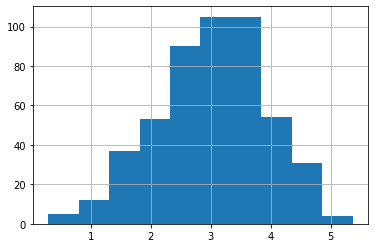

In [361]:

if custo_coletiva_d969['CustoRecente'].mean() > custo_coletiva_d969['MediaCustoAcumulado'].mean():
  Conclusao="Recentemente o lab. gastou mais"
else:
  Conclusao="Recentemente o lab. gastou menos"

print(Conclusao)


custo_coletiva_d969['CustoRecente_log']=custo_coletiva_d969['CustoRecente'].apply(np.log10)

#distribuição de preços no mês mais recente. Veja que temos itens com movimentação maior que R$ 100mil
custo_coletiva_d969[custo_coletiva_d969['CustoRecente_log']>0]['CustoRecente_log'].hist()


DISCRETIZAÇÃO DOS CUSTOS DO MÊS ESCOLHIDO

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(-231.482, 15432.12]        1652
(15432.12, 30864.241]         22
(30864.241, 46296.361]        17
(46296.361, 61728.482]         3
(61728.482, 77160.602]         2
(216049.687, 231481.807]       1
(154321.205, 169753.325]       1
(123456.964, 138889.084]       1
(92592.723, 108024.843]        1
(200617.566, 216049.687]       0
(185185.446, 200617.566]       0
(169753.325, 185185.446]       0
(138889.084, 154321.205]       0
(108024.843, 123456.964]       0
(77160.602, 92592.723]         0
Name: Custo_dist, dtype: int64

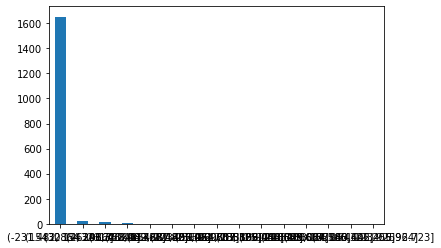

In [362]:
discretizar_coletiva_d969=custo_coletiva_d969

discretizar_coletiva_d969 ['Custo_dist']=pd.cut(discretizar_coletiva_d969['CustoRecente'],15)
display(discretizar_coletiva_d969['Custo_dist'].value_counts())

counts=discretizar_coletiva_d969['Custo_dist'].value_counts()

counts.plot.bar(rot=0)

EXTRAINDO INFORMAÇÕES DE OUTLIERS POR GRÁFICOS

RANKING - ITENS COM MAIORES DESVIOS ENTRE MÉDIA E MÊS ESCOLHIDO


'MAIORES CONSUMOS DE MATERIAL'

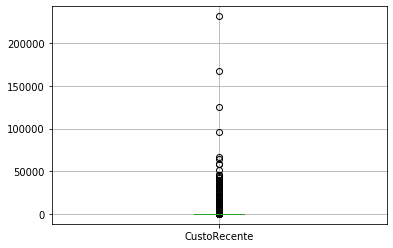

In [363]:
#Neste projeto, outliers são importantes, pois podem ser sinal de anomalia e devem ser observados. Exemplos;
#Erro de faturamento, tabela de preço errada, superprodução, erro de baixa de material
display("MAIORES CONSUMOS DE MATERIAL",custo_coletiva_d969.boxplot(column=['CustoRecente']))

#elimina coluna sem utilidade
custo_coletiva_d969=custo_coletiva_d969.drop(['CustoRecente_log'], axis=1)

custo_coletiva_d969['diferença']=custo_coletiva_d969['CustoRecente'] - custo_coletiva_d969['MediaCustoAcumulado']


In [364]:
#mostra casos de custo maior que R$90mil
display('Skus com os maiores custos', custo_coletiva_d969[custo_coletiva_d969["CustoRecente"] > 90000])





'Skus com os maiores custos'

,Material,Descrição,Preço Unit.,CustoRecente,MediaCustoAcumulado,Custo_dist,diferença
4700,10014052,RGT VITAMIN B12 100T SIEMENS,388.49,125250.318618,75325.297325,"(123456.964, 138889.084]",49925.021293
4754,10014063,RGT CORTISOL ATELL 50T SIEMENS,998.81,166839.459794,76667.656790,"(154321.205, 169753.325]",90171.803004
4769,10014066,RGT SHBG 2PK ATELL 50T SIEMENS,280.35,96324.961765,56081.494350,"(92592.723, 108024.843]",40243.467415
4926,10014105,RGT VITAMIN D TOT ATELL 100T SIEMENS,273.93,231481.807200,140535.677550,"(216049.687, 231481.807]",90946.129650


'MAIORES DESVIOS ABSOLUTOS ENTRE MÉDIA E MÊS ATUAL'

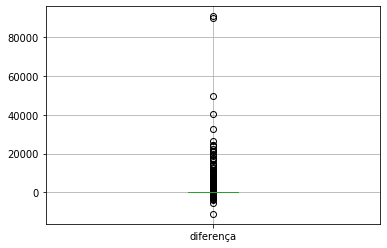

In [365]:
display("MAIORES DESVIOS ABSOLUTOS ENTRE MÉDIA E MÊS ATUAL",custo_coletiva_d969.boxplot(column=['diferença']))

In [366]:
#coloca maiores diferenças de saldo top down
custo_coletiva_d969=custo_coletiva_d969[custo_coletiva_d969['diferença']>0].sort_values('diferença', ascending=False)

display(custo_coletiva_d969.head())


,Material,Descrição,Preço Unit.,CustoRecente,MediaCustoAcumulado,Custo_dist,diferença
4926,10014105,RGT VITAMIN D TOT ATELL 100T SIEMENS,273.93,231481.807200,140535.677550,"(216049.687, 231481.807]",90946.129650
4754,10014063,RGT CORTISOL ATELL 50T SIEMENS,998.81,166839.459794,76667.656790,"(154321.205, 169753.325]",90171.803004
4700,10014052,RGT VITAMIN B12 100T SIEMENS,388.49,125250.318618,75325.297325,"(123456.964, 138889.084]",49925.021293
4769,10014066,RGT SHBG 2PK ATELL 50T SIEMENS,280.35,96324.961765,56081.494350,"(92592.723, 108024.843]",40243.467415
4831,10014081,RGT PSA 100T SIEMENS,96.12,57964.770212,25482.180960,"(46296.361, 61728.482]",32482.589252


In [367]:
#OBSERVANDO OUTLIERS DO MÊS ATUAL E COLOCANDO EM ORDEM DECRESCENTE - FILTRO BASEADO NA TOOLBOX

custo_coletiva_d969[custo_coletiva_d969['CustoRecente']>20000].sort_values('CustoRecente',ascending=False).head(n=20)


,Material,Descrição,Preço Unit.,CustoRecente,MediaCustoAcumulado,Custo_dist,diferença
4926,10014105,RGT VITAMIN D TOT ATELL 100T SIEMENS,273.93,231481.807200,140535.677550,"(216049.687, 231481.807]",90946.129650
4754,10014063,RGT CORTISOL ATELL 50T SIEMENS,998.81,166839.459794,76667.656790,"(154321.205, 169753.325]",90171.803004
4700,10014052,RGT VITAMIN B12 100T SIEMENS,388.49,125250.318618,75325.297325,"(123456.964, 138889.084]",49925.021293
4769,10014066,RGT SHBG 2PK ATELL 50T SIEMENS,280.35,96324.961765,56081.494350,"(92592.723, 108024.843]",40243.467415
4915,10014104,RGT ANTI TIREOGLOBULINA 100T SIEMENS,998.80,66134.073176,41741.350200,"(61728.482, 77160.602]",24392.722976
2164,10007058,RGT HEMOGLOB AFFINITY 2000T TRINITY,2600.00,63790.235294,39200.200000,"(61728.482, 77160.602]",24590.035294
4744,10014061,RGT ESTRADIOL ATELL 100T SIEMENS,300.00,58027.235294,36722.400000,"(46296.361, 61728.482]",21304.835294
4831,10014081,RGT PSA 100T SIEMENS,96.12,57964.770212,25482.180960,"(46296.361, 61728.482]",32482.589252
5261,10014213,RGT ANTI HCV G2 ELEC E2G 300T ROCHE,494.15,51836.044324,27837.693175,"(46296.361, 61728.482]",23998.351149
5042,10014148,SOL WASH 3000ML SIEMENS,71.70,45930.176471,26779.950000,"(30864.241, 46296.361]",19150.226471


In [368]:
#OBSERVANDO OUTLIERS DOS MAIORES DESVIOS E COLOCANDO EM ORDEM DECRESCENTE - FILTRO BASEADO NA TOOLBOX

custo_coletiva_d969[custo_coletiva_d969['diferença']>5000].head(n=20)

,Material,Descrição,Preço Unit.,CustoRecente,MediaCustoAcumulado,Custo_dist,diferença
4926,10014105,RGT VITAMIN D TOT ATELL 100T SIEMENS,273.93,231481.807200,140535.677550,"(216049.687, 231481.807]",90946.129650
4754,10014063,RGT CORTISOL ATELL 50T SIEMENS,998.81,166839.459794,76667.656790,"(154321.205, 169753.325]",90171.803004
4700,10014052,RGT VITAMIN B12 100T SIEMENS,388.49,125250.318618,75325.297325,"(123456.964, 138889.084]",49925.021293
4769,10014066,RGT SHBG 2PK ATELL 50T SIEMENS,280.35,96324.961765,56081.494350,"(92592.723, 108024.843]",40243.467415
4831,10014081,RGT PSA 100T SIEMENS,96.12,57964.770212,25482.180960,"(46296.361, 61728.482]",32482.589252
4774,10014067,RGT FPSA LIV 50T SIEMENS,48.05,45298.628735,18975.761850,"(30864.241, 46296.361]",26322.866885
2164,10007058,RGT HEMOGLOB AFFINITY 2000T TRINITY,2600.00,63790.235294,39200.200000,"(61728.482, 77160.602]",24590.035294
4915,10014104,RGT ANTI TIREOGLOBULINA 100T SIEMENS,998.80,66134.073176,41741.350200,"(61728.482, 77160.602]",24392.722976
5261,10014213,RGT ANTI HCV G2 ELEC E2G 300T ROCHE,494.15,51836.044324,27837.693175,"(46296.361, 61728.482]",23998.351149
4671,10014044,RGT FT3 LIV 60T SIEMENS,94.12,31725.471318,9416.094220,"(30864.241, 46296.361]",22309.377098


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


'CORRELAÇÃO ENTRE CUSTO E QUANT. CONSUMIDA'

0.6315064517554723

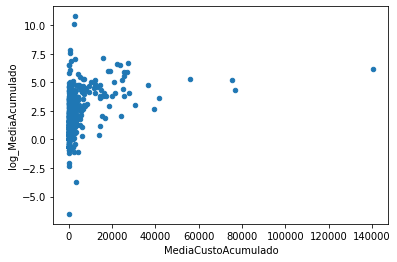

In [369]:

custo_coletiva_d969_scatter['MediaAcumulado']=custo_coletiva_d969_scatter.iloc[:,(13-meses_custo):13].mean(axis=1)
custo_coletiva_d969_scatter['log_MediaAcumulado']=custo_coletiva_d969_scatter['MediaAcumulado'].apply(np.log) #colocado no log para melhorar visualização
#IDADE MÉDIA DE ITENS CONSUMIDOS NO ACUMULADO E O CUSTO MÉDIO DO ACUMULADO 
#NÃO POSSUI GRANDE CORRELAÇÃO. ISTO OCORRE PORQUE OS INSUMOS POSSUEM PREÇOS MUITO DIFERENTES. 
#PORTANTO,A QUANTIDADE UNIDADES DE BAIXADAS/CONNSUMIDAS NÃO IMPLICA EM MAIORES CUSTOS.

custo_coletiva_d969_scatter.plot.scatter(x='MediaCustoAcumulado', y='log_MediaAcumulado')

display("CORRELAÇÃO ENTRE CUSTO E QUANT. CONSUMIDA",custo_coletiva_d969_scatter.corr(method='spearman')['MediaCustoAcumulado']['log_MediaAcumulado'])



'CORRELAÇÃO ENTRE CUSTO ACUMULADO E CUSTO MAIS RECENTE'

0.8691749048562515

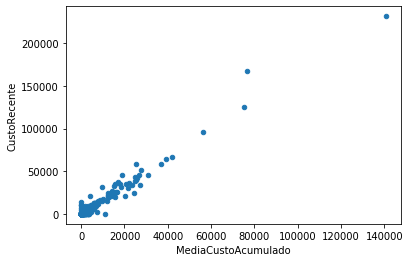

In [370]:
#SE OBSERVA-SE QUE A CORRELAÇÃO É MUITO MAIS FORTE ENTRE O CUSTO DO ACUMULADO E OS CUSTO DO ÚLTIMO MÊS.
#ISTO JÁ ERA ESPERADO, UMA VEZ QUE ISTO DEPENDE DA DEMANDA DE EXAMES DO LABORATÓRIO E NÃO HÁ VARIAÇÕES TÃO FORTES.
custo_coletiva_d969_scatter.plot.scatter(x='MediaCustoAcumulado', y='CustoRecente')

display("CORRELAÇÃO ENTRE CUSTO ACUMULADO E CUSTO MAIS RECENTE",custo_coletiva_d969_scatter.corr(method='spearman')['MediaCustoAcumulado']['CustoRecente'])



#TODAVIA, A CORRELAÇÃO ENTRE A QUANT

ENCONTRANDO OUTLIERS PREJUDICIAIS A PARTIR DO DESVIO PADRÃO

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


9       0.007084
16      0.000000
18      0.000057
21      0.000000
27      0.000000
          ...   
6733    0.001133
6734    0.000000
6736    0.000216
6738    0.000000
6751    0.000000
Name: std_norm, Length: 1700, dtype: float64

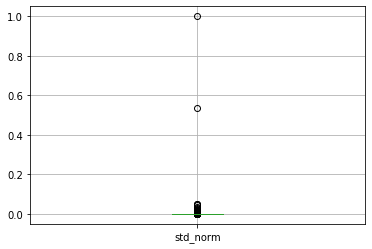

In [371]:

coletiva_d969con['std']=coletiva_d969con.iloc[:,2:14].std(axis=1)

coletiva_d969con['std_norm'] = (coletiva_d969con['std'] - coletiva_d969con['std'].min()) / (coletiva_d969con['std'].max() - coletiva_d969con['std'].min())

display(coletiva_d969con['std_norm'])

coletiva_d969con.boxplot(column=['std_norm'])


QUADRO COM OS OUTLIERS QUE DEVEM SER REMOVIDOS 

In [372]:
#É PRECISO ENTENDER PORQUE HÁ TANTA VARIAÇÃO DE CONSUMO, ISTO PREJUDICA O SETOR DE COMPRAS.
display(coletiva_d969con[coletiva_d969con['std_norm']> 0.4]) 

,Material,Descrição,Cons.DEZ/2018,Cons.JAN/2019,Cons.FEV/2019,Cons.MAR/2019,Cons.ABR/2019,Cons.ABR/2019,Cons.JUN/2019,Cons.JUL/2019,Cons.AGO/2019,Cons.SET/2019,Cons.OUT/2019,Cons.NOV/2019,mediaCons,std,std_norm
209,10009849,ALCA AM PLAST DESC 1UL CRAL,7700.0,10400.0,9600.0,6000.0,17600.0,17600.0,23500.0,27100.0,28200.0,21800.0,19500.0,41294.117647,30397.058824,10171.748309,0.538745
6488,20003623,COPO DESC P/AGUA 180 /200ML,43.0,6048.0,5100.0,10000.0,25500.0,25500.0,15080.0,52500.0,57500.0,37700.0,30100.0,39882.352941,34991.176471,18880.452469,1.000000


EXPORTANDO DADOS PARA EXCEL 

In [0]:
#using writer
from pandas import ExcelWriter

writer = pd.ExcelWriter('Resultado_beta.xlsx')
sort_ascent.to_excel(writer,sheet_name='Abastecimento', index=False, header=True)
sort_ascent_roche.to_excel(writer, sheet_name='ROCHE', index=False, header=True)
sort_ascent_siemens.to_excel(writer,sheet_name='SIEMENS', index=False, header=True)
sort_ascent_phadia.to_excel(writer,sheet_name='PHADIA', index=False, header=True)
sort_ascent_horiba.to_excel(writer,sheet_name='HORIBA', index=False, header=True)

writer.save()